# Abstract
This blog post presents the development and application of a machine learning-based logistic regression model to assess the risk of loan default associated with loan applicants and subsequently determining the optimal threshold for maximizing profit for a bank. The model leverages various applicant features to assign risk scores, enabling precise categorization of applicants into high and low-risk groups. Through further analysis, the optimal threshold for loan approval is identified, balancing the trade-off between minimizing risk and maximizing profitability. By utilizing this threshold, the model  decides to approve or deny loans based on the risk scores of individual applicants. Upon training the model, the trained weights of the model showed that the most influential features for a potential loan applicant were the loan amount and the applicant's income.

# Part A: Grab the Data

Here I import the data and get a quick snapshot of the column names and types of data within it.

In [2]:
import pandas as pd
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv"
df_train = pd.read_csv(url)

In [3]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


# Part B: Explore the Data
Create at least two visualizations and one summary table in which you explore patterns in the data. You might consider some questions like:

* How does loan intent vary with the age, length of employment, or homeownership status of an individual?
* Which segments of prospective borrowers are offered low interest rates? Which segments are offered high interest rates?
* Which segments of prospective borrowers have access to large lines of credit?

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

For my first visualization, I created a density plot of the Initial Loan Rate of a loan applicant vs. their income. While not many trends are immediately apparent, there seems to be some correlation between greater income and lower initial loan rate, when noticing the darker/denser grouping of data points in the lower-right area of the data.

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


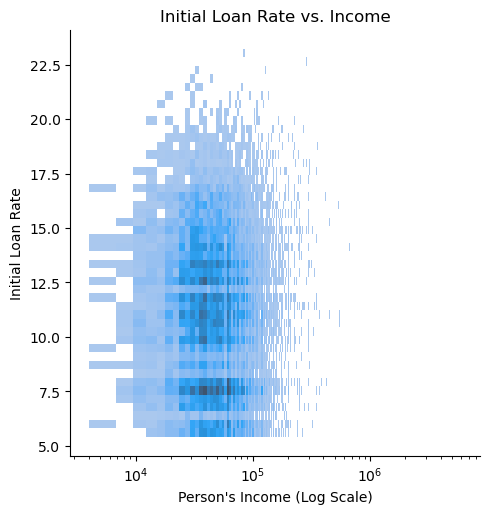

In [5]:
plot1 = sns.displot(data= df_train, x= 'person_income', y= 'loan_int_rate')
plt.xscale('log')
plot1.set(xlabel= "Person's Income (Log Scale)", ylabel= "Initial Loan Rate", title= 'Initial Loan Rate vs. Income')
plot1

I then plotted a catplot of a loan applicants income against their home ownership types. Again, there did not seem to be a strong trend, but there was a slightly higher median of income for loan applicants renting their homes as opposed to mortgaging or owning. Perhaps this correlates to a trend in which a person needs a larger income in order to afford to rent certain types of homes (i.e. expensive apartments or condos). Like the weak correlation above, it seems that not much can be extraploated from this visualization that could prove helpful to prediciting loan default rates of a given person.

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed

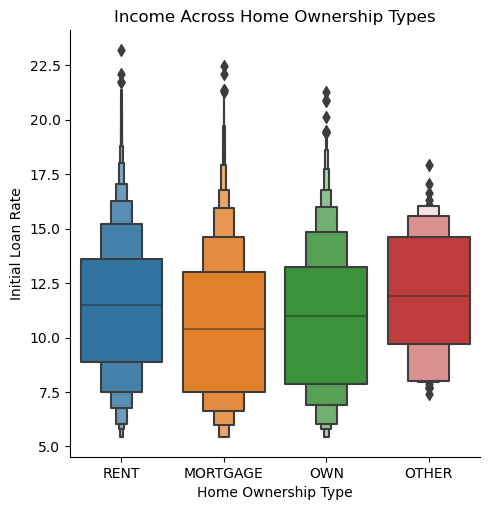

In [6]:
plot2 = sns.catplot(data= df_train, x= 'person_home_ownership', y= 'loan_int_rate', kind= "boxen")
plot2.set(xlabel= "Home Ownership Type", ylabel= "Initial Loan Rate", title= 'Income Across Home Ownership Types')
plot2

For the third visualization, I created a catplot that mapped one's initial loan rate against whether or not they have had a past loan default. Here, I found a strong trend of higher initial loan rates for those who have previously defaulted on a loan. This correlation is intuitive, as most banks would want to protect their interests from possible future defaults through higher loan rates, and people who have defaulted on loans in the past are often thought to be more likely to default in the future, than those who have never defaulted on a loan.

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


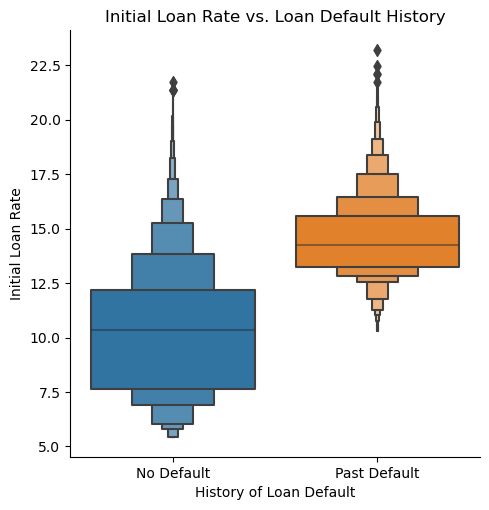

In [7]:
temp = df_train.copy()
temp['cb_person_default_on_file'] = temp['cb_person_default_on_file'].str.replace('Y', 'Past Default')
temp['cb_person_default_on_file'] = temp['cb_person_default_on_file'].str.replace('N', 'No Default')


plot3 = sns.catplot(data= temp, x= 'cb_person_default_on_file', y= 'loan_int_rate', kind= 'boxen')
plot3.set(xlabel= "History of Loan Default", ylabel= "Initial Loan Rate", title= 'Initial Loan Rate vs. Loan Default History')
plot3

I then had the idea to separate all of the loan applicants by age group, as perhaps there were trends that existed between them. I chose the categories of <30, 30-50, 50-70, 70-90, and 90+. I then compared the number of loan applications from each group, and found that the dataset is mostly comprised of loan applications from people younger than 30, at that there are little to no applications from people older than 50 in the data set.

In [8]:
bins= [0, 30, 50, 70, 90, 150]
labels= ["<30", "30-50", "50-70", "70-90", "90+"]
df_train['person_age_group'] = pd.cut(df_train["person_age"], bins=bins, labels=labels, right=False)

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


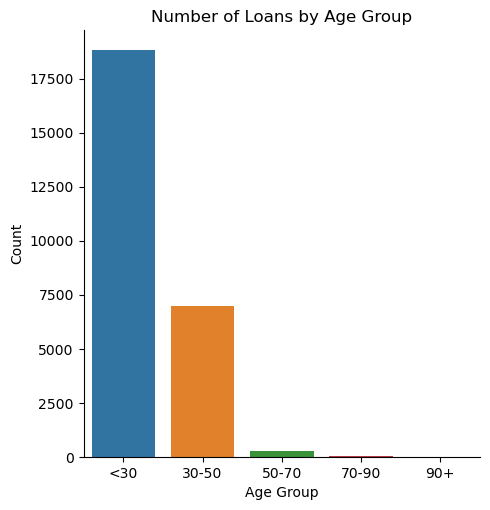

In [9]:
plot3 = sns.catplot(df_train, x= "person_age_group", y= None, kind= 'count')
plot3.set(xlabel= 'Age Group', ylabel= 'Count', title= "Number of Loans by Age Group")
plot3

I then wanted to see the distribution of loan intents across age groups, so I created the following summary table. Within the <30 group, the most common intent was education, the least common was home improvement, and the rest were mostly comparable. This is intuitive as most young people are focused on going to college or graduate school and take out loans to do so; they also often do not have houses to make improvements upon during this time in their lives. The 30-50 group generally had an even distribution of loan intents. The 50-70 group saw a large amount of loan applications with the intent of 'personal'. Perhaps this is due to most of these people being retired, yet living outside of their means, and are thus relying on the money of bank loans to pay for some of their lifestyles instead of their old incomes.

In [10]:
sum_table = df_train.groupby(["person_age_group", 'loan_intent']).size()
sum_table

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\2851417689.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_table = df_train.groupby(["person_age_group", 'loan_intent']).size()


person_age_group  loan_intent      
<30               DEBTCONSOLIDATION    3028
                  EDUCATION            4001
                  HOMEIMPROVEMENT      1881
                  MEDICAL              3429
                  PERSONAL             3129
                  VENTURE              3340
30-50             DEBTCONSOLIDATION    1114
                  EDUCATION            1106
                  HOMEIMPROVEMENT      1001
                  MEDICAL              1363
                  PERSONAL             1156
                  VENTURE              1239
50-70             DEBTCONSOLIDATION      35
                  EDUCATION              18
                  HOMEIMPROVEMENT        20
                  MEDICAL                35
                  PERSONAL              118
                  VENTURE                34
70-90             DEBTCONSOLIDATION       1
                  EDUCATION               0
                  HOMEIMPROVEMENT         0
                  MEDICAL               

# Part C: Build a Model

Please use any technique to construct a score function and threshold for predicting whether a prospective borrower is likely to default on a given loan. You may use all the features in the data except *loan_grade* (and the target variable *loan_status*), and you may choose any subset of these. There are several valid ways to approach this modeling task:

* Choose features and estimate entries of a weight vector **w**
 by hand (this is allowed but not recommended).
* (Recommended): Choose your features, estimate new ones if needed, and fit a score-based machine learning model to the data. My suggestion is *LogisticRegression*. Once you have fit a logistic regression model, the weight vector **w**
 is stored as the attribute *model.coef_*.
 
I suggest that you try several combinations of features, possibly including some which you create, and test out which combinations work best with cross-validation.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # support vector classifier
from mlxtend.plotting import plot_decision_regions # for visualization later
from sklearn.model_selection import cross_val_score
import numpy as np

Here I am removing the loan_grade and loan_status features from the dataset, saving loan_status as the target variable for later use. Additionally, I created 'dummy' variables for all of the qualitative features (e.g., person_home_mortgage, loan_intent, etc.), so that it can be processed by my logistic regression model.

In [12]:
# HERE one-hot encode all of the qual variables

def prepare_data(df):
  df = df.dropna()
  y = df["loan_status"]
  df = df.drop(["loan_status", "loan_grade"], axis = 1)
  df = pd.get_dummies(df)
  return df, y

X_train, y_train = prepare_data(df_train)

In [13]:
# feature names
features = X_train.columns
LR = LogisticRegression(max_iter= 10000)
LR.fit(X_train[features], y_train)

LogisticRegression(max_iter=10000)

Here I show the optimal weights for all of the features that the model was trained on. It seems that the most important factors were the loan amount and the applicant's income.

In [14]:
coefficients = LR.coef_

weights_table = pd.DataFrame({'Feature': features, 'Weight': coefficients[0]})
weights_table

,Feature,Weight
0,person_age,-6.362318e-08
1,person_income,-4.057367e-05
2,person_emp_length,-2.492166e-08
3,loan_amnt,1.065581e-04
4,loan_int_rate,9.498579e-08
5,loan_percent_income,2.549965e-09
6,cb_person_cred_hist_length,-1.225154e-08
7,person_home_ownership_MORTGAGE,-6.571695e-09
8,person_home_ownership_OTHER,5.824537e-11
9,person_home_ownership_OWN,-3.939349e-09


In [15]:
LR.score(X_train[features], y_train)

0.8080062862880342

# Part D: Find a Threshold

Given assumptions for our model:
1. If the loan is repaid in full, the profit for the bank is:
    
    $\text{loan\_amt}\times(1+0.25\times\text{loan\_int\_rate})^{10} - \text{loan\_amt}$
2. If the borrower defaults on the loan, the "profit" is:

    $\text{loan\_amt}\times(1+0.25\times\text{loan\_int\_rate})^{3}-(1.7\times\text{loan\_amt})$

After training my model, I had it predict the probabilities of each data point belonging to class 0 or class 1, i.e., the receiver of the bank loan either repaying or defaulting on their loan. I then created the 'profit_likeli' feature within the training set, which represents the probability of the loanee fully repaying the bank loan, thereby making the bank a profit. Instead of creating a "risk" score to quantify how likely the loanee is to default, I chose this metric, as the prospective loss due to a loan default is expressed as an impact on the profit in the given assumptions of the model.

In [16]:
from sklearn.metrics import confusion_matrix

train_preds = LR.predict_proba(X_train[features])
X_train["profit_likeli"] = train_preds[:, 0]


I followed the equations above to create new columns in the dataset that define the cost or profit a bank can expect if the borrower defaults or repays their loan.

In [17]:
X_train['profit'] = X_train["loan_amnt"]*(1+0.25*(X_train['loan_int_rate']/100))**10 - X_train['loan_amnt']
X_train['cost'] = X_train['loan_amnt']*(1+0.25*(X_train['loan_int_rate']/100))**3 - (1.7*X_train['loan_amnt'])

After computing the profit likelihoods, the projected profit, and the projected cost of each loan applicant, I was then able to search for the optimal threshold by defining a function that would calculate the expected total profit of the bank if it made loan approval decisions on my profit likelihood feature using a given threshold. This function works by using the threshold to either approve or deny the loan application (0 if approve, 1 if deny, as this will match up with our y_train labels). This approval is calculated by testing whether the profit_likeli is greater than the given threshold. Then, if the approved loans are correct (match up with the actual y_train label), the expected profit will be added to the total; if the approved loans are incorrect (contradict the actual y_train labels), the expected cost will instead be added to the total.

In [18]:
def calculate_profit(threshold, df, y):
    df['expect_default'] = np.where(df['profit_likeli'] > threshold, 0, 1)
    df['correct'] = np.where(df['expect_default'] == y, 1, 0)

    approved = df[df['expect_default'] == 0]

    return np.where(approved['correct'] == 1, approved['profit'], approved['cost']).sum()

Below, I graphed the expected profits of my model over 1000 different thresholds between 0 and 1. It appears that the optimal thresholds is somewhere close to 0.6.

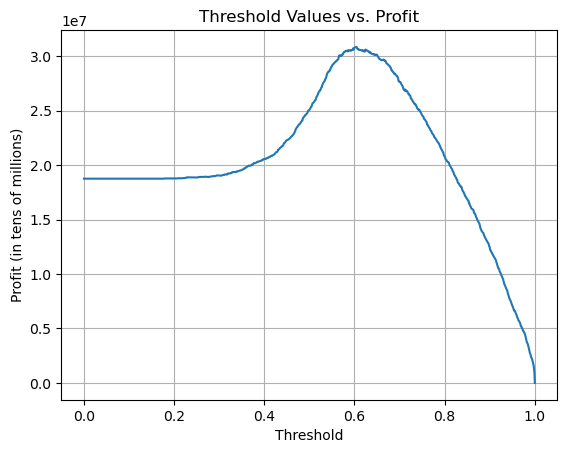

In [19]:
thresholds = np.linspace(0, 1, 1000)
expected_profits = [calculate_profit(threshold, X_train, y_train) for threshold in thresholds]

plt.plot(thresholds, expected_profits)
plt.title("Threshold Values vs. Profit")
plt.xlabel("Threshold")
plt.ylabel("Profit (in tens of millions)")
plt.grid(True)
plt.show()

I then used the 'optimize' object from the scipy Python library to find the exact value of the optimal threshold, and the resulting maximimum profit.

In [20]:
from scipy import optimize

maximize_func = lambda x: -calculate_profit(x, X_train, y_train)

maximization = optimize.minimize_scalar(maximize_func, bounds= (0, 1))
print("The optimum threshold is: " + str(maximization.x))
print("The optimal profit, using the threshold, is: " + str(round(-maximize_func(maximization.x), 2)))

The optimum threshold is: 0.6047470824523239
The optimal profit, using the threshold, is: 30850532.36


Since there were 22,907 data points that I trained my model on, and the profit expected using my optimal threshold was 30,850,532.36, my estimate of the bank's expected profit per borrower on the training set is 1346.77 dollars in profit per borrower.

# Part E: Evaluate  Model From the Bank's Perspective

Now I will test my finalized weight vector and optimal threshold against the test set.

In [21]:
url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/test.csv"
df_test = pd.read_csv(url)

I performed the same data pre-processing steps on the testing data as I did to the training data, and then calculated the expected profit of the bank on the testing data using my trained model and optimal threshold.

In [22]:
bins= [0, 30, 50, 70, 90, 150]
labels= ["<30", "30-50", "50-70", "70-90", "90+"]
df_test['person_age_group'] = pd.cut(df_test["person_age"], bins=bins, labels=labels, right=False)

X_test, y_test = prepare_data(df_test)

test_preds = LR.predict_proba(X_test[features])
X_test["profit_likeli"] = test_preds[:, 0]

X_test['profit'] = X_test["loan_amnt"]*(1+0.25*(X_test['loan_int_rate']/100))**10 - X_test['loan_amnt']
X_test['cost'] = X_test['loan_amnt']*(1+0.25*(X_test['loan_int_rate']/100))**3 - (1.7*X_test['loan_amnt'])

expected = calculate_profit(maximization.x, X_test, y_test)

print("The expected profit per borrower on the test set is: " + str(round(expected / X_test.shape[0], 2)))

The expected profit per borrower on the test set is: 1273.62


# Part F: Evaluate Model From the Borrower's Perspective

Question 1: Is it more difficult for people in certain age groups to access credit under my proposed system?

Fortunately, in my earlier data preprocessing, I have already given each loan applicant an age group designation, so it should be fairly simple to answer this question.

In [23]:
X_test['person_age_group'] = pd.cut(df_test["person_age"], bins=bins, labels=labels, right=False)
X_test.groupby('person_age_group')['expect_default'].aggregate(np.mean)

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\2666120760.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test.groupby('person_age_group')['expect_default'].aggregate(np.mean)
C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\2666120760.py:2: FutureWarning: The provided callable <function mean at 0x000002A1CB3270D0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X_test.groupby('person_age_group')['expect_default'].aggregate(np.mean)


person_age_group
<30      0.175320
30-50    0.153194
50-70    0.166667
70-90    0.500000
90+           NaN
Name: expect_default, dtype: float64

With this summary table, we can see the model's interpretation of the average likelihood across age groups that a loan applicant will default on their loan payment, and therefore should be denied access to the bank's credit. It looks like the model believes the age group of 70-90 to be the riskiest by far, and then those who are <30 have a 17.53% expected chance of defaulting, followed by a 16.67% chance for those 50-70, and finally a 15.32% chance for those 30-50. However, as we have seen in the data exploration section of this blog post, the number of people in each age group in this data set is heavily skewed, with there being many more loan applicants on the younger side. Thus, it could be said that if there were more applicants in the 70-90 range, the model would assess their risk to be comparable to the other age groups, as opposed to the current outlier of 50% expected risk of default.

Question 2: Is it more difficult for people to get loans in order to pay for medical expenses? How does this compare with the actual rate of default in that group? What about people seeking loans for business ventures or education?

In [36]:
X_test.groupby('loan_intent_MEDICAL')['expect_default'].aggregate(np.mean)

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\29578798.py:1: FutureWarning: The provided callable <function mean at 0x000002A1CB3270D0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X_test.groupby('loan_intent_MEDICAL')['expect_default'].aggregate(np.mean)


loan_intent_MEDICAL
False    0.160155
True     0.209692
Name: expect_default, dtype: float64

It appears that my model on average assigns a loan default risk score of 5% higher to those applying for a loan to pay off medical expenses than applicants intending to use the loan for other purposes.

In [35]:
df_test.groupby('loan_intent')['loan_status'].aggregate(np.mean)

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\3309084637.py:1: FutureWarning: The provided callable <function mean at 0x000002A1CB3270D0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_test.groupby('loan_intent')['loan_status'].aggregate(np.mean)


loan_intent
DEBTCONSOLIDATION    0.279497
EDUCATION            0.167421
HOMEIMPROVEMENT      0.246088
MEDICAL              0.281553
PERSONAL             0.219227
VENTURE              0.145701
Name: loan_status, dtype: float64

While my model's expected default rate for medical expense loans is lower than the true default rate for medical expense loans (21% vs. 28%), it does reflect the fact that medical expense loans are more likely to be defaulted on than any other loan purposes.

In [37]:
X_test.groupby('loan_intent_EDUCATION')['expect_default'].aggregate(np.mean)

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\4235614756.py:1: FutureWarning: The provided callable <function mean at 0x000002A1CB3270D0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X_test.groupby('loan_intent_EDUCATION')['expect_default'].aggregate(np.mean)


loan_intent_EDUCATION
False    0.167728
True     0.176020
Name: expect_default, dtype: float64

In [38]:
X_test.groupby('loan_intent_VENTURE')['expect_default'].aggregate(np.mean)

C:\Users\oscar\AppData\Local\Temp\ipykernel_12908\4016549862.py:1: FutureWarning: The provided callable <function mean at 0x000002A1CB3270D0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  X_test.groupby('loan_intent_VENTURE')['expect_default'].aggregate(np.mean)


loan_intent_VENTURE
False    0.173904
True     0.147303
Name: expect_default, dtype: float64

Furthermore, my model's assessment of the risk score for loan applications for the purposes of education or business ventures is far lower than those for medical expenses (17.6% and 14.7% respectively, against 21%). However, the model's risk score more accurately represents the true default rate of these two demographics, while the model's score for medical expense loans is, counterintuitively, lower than the true loan default rate. Perhaps this reflects the fact that my model uses the features of loan amount and applicant's income to a greater weight than loan intent when making an approval prediction.

Question 3: How does a person's income level impact the ease with which they can access credit under my decision system?

c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\oscar\anaconda3\envs\ml-0451\lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


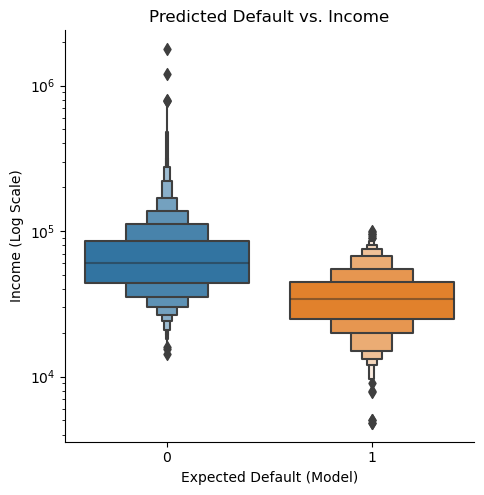

In [45]:
plot4 = sns.catplot(data= X_test, x= 'expect_default', y= 'person_income', kind= 'boxen')
plot4.set(yscale= 'log')
plot4.set(xlabel= "Expected Default (Model)", ylabel= "Income (Log Scale)", title= 'Predicted Default vs. Income')
plot4

Using this graph, it appears that there is a large influence that a loan applicant's income has on the model's assessment of whether the loan is expected to default or not. The higher a person's income is, the more likely that the model will not predict a default on loan payment. Since the scale used for income is a logarithmic scale, this advantage is likely starker than it initially appears in this visualization.

# Discussion
In summary, this blog post has detailed the development and application of a machine learning-based logistic regression model for loan risk assessment and decision-making in the banking sector. Through the analysis of various applicant features, the model assigns risk scores to quantify applicants based on their expected risk of defaulting on a loan. Importantly, the post highlights the utility of threshold optimization for loan approval, showing how a bank could calculate the optimal balance between risk mitigation and profit maximization. My model gave the most importance to the data features of loan amount and applicant's income when assessing whether the loan applicant will default on payments.
I define fairness as the equality of opportunity between individuals with similar features, not considering features that exist outside of their sphere of control. For example, if a bank is considering two identical applicants, but one has defaulted on a loan in the past, and the other has not, I believe that it would be considered 'fair' for a bank to deny the loan for the applicant with a history of defaulting, as the past loan default would be a feature of an applicant that they have control over. However, I believe that this conception of 'fairness' is put at odds with the very notion of machine learning, in that this model's main goal is to use historical data from many distinct loan applicants to predict the likelihood of repayment from a new applicant. In essence, this process relies heavily on features and data that lay outside the sphere of control of the new applicant, and uses this information in the decision process of loan approval. Simply because many applicants who seek loans for medical expenses have high rates of default, it will be far more difficult for new applicants seeking a loan for medical expenses to access credit. This does not adhere to my conception of fairness, as the new applicant has no control over whether the past loan applicants defaulted on or repaid their loans. Unfortunately, the use of historical data in prediction is one of the best tools available for banks to determine loan repayment success in new applicants and maximize profits.